#### Project Note 2 - MileStone 2

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output...

In [1]:
!pip install -q pydicom 
!pip install -q tqdm 
!pip install -q imgaug 

In [2]:
import os
#### code added below ####
os.chdir('/kaggle/input/rsna-pneumonia-detection-challenge')

In [3]:
import os 
import sys
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.patches as patches
import seaborn as sns
%matplotlib inline
import pydicom
import pydicom as dcm
#from tqdm import tqdm_notebook
from tqdm.notebook import tqdm
import random
import math
import cv2
import json
from imgaug import augmenters as iaa
import glob 
from skimage import measure
from skimage.transform import resize

import warnings
warnings.filterwarnings('ignore')

##### Lets create Basic CNN model with unqiue dataset train_class_d

In [4]:
source_df = pd.read_csv('/kaggle/input/custom/train_class_df.csv')

In [5]:
source_df = source_df[['patientId','x','y','width','height','Target']]

In [6]:
source_df.reset_index(drop=True, inplace=True)

In [7]:
source_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26684 entries, 0 to 26683
Data columns (total 6 columns):
patientId    26684 non-null object
x            26684 non-null float64
y            26684 non-null float64
width        26684 non-null float64
height       26684 non-null float64
Target       26684 non-null int64
dtypes: float64(4), int64(1), object(1)
memory usage: 1.2+ MB


In [8]:
source_df.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0.0,0.0,0.0,0.0,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,0.0,0.0,0.0,0.0,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,0.0,0.0,0.0,0.0,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0.0,0.0,0.0,0.0,0
4,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1


##### Lets load the train label information

In [9]:
target_locations = {}

for index, rows in source_df.iterrows():
  patientId = rows[0]
  location = rows[1:5]
  target = rows[5]  
  if target == 1:
    location = [int(float(i)) for i in location]
    #print('ID::{}, target::{}'.format(patientId,target))
    if patientId in target_locations:
      target_locations[patientId].append(location)
    else:
      target_locations[patientId] = [location]

In [10]:
print(target_locations["c1f7889a-9ea9-4acb-b64c-b737c929599a"])

[[233, 424, 201, 356]]


##### Lets read the train images and split into train and valaditaion sets

In [11]:
# load and shuffle filenames
folder = 'stage_2_train_images'
filenames = os.listdir(folder)
random.seed(42)
random.shuffle(filenames)
# split into train and validation filenames
validation_split = 0.1
split_index = int((1 - validation_split) * len(filenames))

train_filenames = filenames[:split_index]
valid_filenames = filenames[split_index:]

print(len(train_filenames), len(valid_filenames))

24015 2669


##### Lets create a helper function to load the image data on the fly when ever needed...

In [12]:
from keras.utils import Sequence

class generator(Sequence):
    
    def __init__(self, folder, filenames, target_locations=None, batch_size=32, image_size=256, shuffle=True, augment=False, predict=False):
        self.folder = folder
        self.filenames = filenames
        self.target_locations = target_locations
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augment = augment
        self.predict = predict
        self.on_epoch_end()
        
    def __load__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # create empty mask
        msk = np.zeros(img.shape)
        # get filename without extension
        filename = filename.split('.')[0]
        # if image contains pneumonia
        if filename in target_locations:
            # loop through pneumonia
            for location in target_locations[filename]:
                # add 1's at the location of the pneumonia
                x, y, w, h = location
                msk[y:y+h, x:x+w] = 1
        # if augment then horizontal flip half the time
        if self.augment and random.random() > 0.5:
            img = np.fliplr(img)
            msk = np.fliplr(msk)
        # resize both image and mask
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        msk = resize(msk, (self.image_size, self.image_size), mode='reflect') > 0.5
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        msk = np.expand_dims(msk, -1)
        return img, msk
    
    def __loadpredict__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # resize image
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        return img
        
    def __getitem__(self, index):
        # select batch
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]
        # predict mode: return images and filenames
        if self.predict:
            # load files
            imgs = [self.__loadpredict__(filename) for filename in filenames]
            # create numpy batch
            imgs = np.array(imgs)
            return imgs, filenames
        # train mode: return images and masks
        else:
            # load files
            items = [self.__load__(filename) for filename in filenames]
            # unzip images and masks
            imgs, msks = zip(*items)
            # create numpy batch
            imgs = np.array(imgs)
            msks = np.array(msks)
            return imgs, msks
        
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.filenames)
        
    def __len__(self):
        if self.predict:
            # return everything
            return int(np.ceil(len(self.filenames) / self.batch_size))
        else:
            # return full batches only
            return int(len(self.filenames) / self.batch_size)

Using TensorFlow backend.


##### Lets Build the CNN Model:

In [32]:
# Importing the Keras libraries and packages
import keras
import tensorflow as tf
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, LeakyReLU, MaxPool2D, Activation, UpSampling2D, Concatenate
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [41]:
def create_sample(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 1, padding='same', use_bias=False)(x)
    x = keras.layers.MaxPool2D(2)(x)
    return x

def create_resblock(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    return keras.layers.add([x, inputs])

def create_network(input_size, channels, n_blocks=2, depth=4):
    # input
    inputs = keras.Input(shape=(input_size, input_size, 1))
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(inputs)
    # residual blocks
    for d in range(depth):
        channels = channels * 2
        x = create_sample(channels, x)
        for b in range(n_blocks):
            x = create_resblock(channels, x)
    # output
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(1, 1, activation='sigmoid')(x)
    outputs = keras.layers.UpSampling2D(2**depth)(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [44]:
def iou_loss(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true * y_pred)
    score = (intersection + 1.) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + 1.)
    return 1 - score

def iou_bce_loss(y_true, y_pred):
    return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) + 0.5 * iou_loss(y_true, y_pred)

# mean iou as a metric
def mean_iou(y_true, y_pred):
    y_pred = tf.round(y_pred)
    intersect = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    smooth = tf.ones(tf.shape(intersect))
    return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))

In [17]:
BATCH_SIZE = 32
IMAGE_SIZE = 256

##### Create model, compile and print the summary

In [42]:
model = create_network(input_size=IMAGE_SIZE, channels=32, n_blocks=2, depth=5)
#model = create_network(input_size=IMAGE_SIZE, channels=32)
model.compile(optimizer='adam',
              loss=iou_bce_loss,
              metrics=['accuracy', mean_iou])

In [43]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_146 (Conv2D)             (None, 256, 256, 32) 288         input_10[0][0]                   
__________________________________________________________________________________________________
batch_normalization_137 (BatchN (None, 256, 256, 32) 128         conv2d_146[0][0]                 
__________________________________________________________________________________________________
leaky_re_lu_120 (LeakyReLU)     (None, 256, 256, 32) 0           batch_normalization_137[0][0]    
____________________________________________________________________________________________

In [48]:
checkpoint = keras.callbacks.ModelCheckpoint("/kaggle/working/model_{val_loss:.4f}.h5",monitor='val_loss',
                             verbose=1, save_best_only=False,save_weights_only=True, mode="auto")

es = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

#lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')

In [49]:
def cosine_annealing(x):
    lr = 0.001
    epochs = 5
    return lr*(np.cos(np.pi*x/epochs)+1.)/2
learning_rate = tf.keras.callbacks.LearningRateScheduler(cosine_annealing)

##### Resize all the train and test inputs to size 256X256 to fit to the Model input requirements

In [46]:
train_gen = generator(folder, train_filenames, target_locations, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=True, augment=True, predict=False)
valid_gen = generator(folder, valid_filenames, target_locations, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=False, predict=False)

##### Lets train the model

In [50]:
history = model.fit_generator(train_gen, validation_data=valid_gen, callbacks=[checkpoint,es,learning_rate], epochs=5, shuffle=True)

Epoch 1/5
750/750 [==============================] - 3029s 4s/step - loss: 0.5095 - accuracy: 0.9751 - mean_iou: 0.0739 - val_loss: 0.5037 - val_accuracy: 0.9721 - val_mean_iou: 0.1194

Epoch 00001: saving model to /kaggle/working/model_0.5037.h5
Epoch 2/5
750/750 [==============================] - 2853s 4s/step - loss: 0.4856 - accuracy: 0.9745 - mean_iou: 0.1255 - val_loss: 0.6198 - val_accuracy: 0.9006 - val_mean_iou: 0.0791

Epoch 00002: saving model to /kaggle/working/model_0.6198.h5


##### Lets plot loss, accuracy and other metrics identified

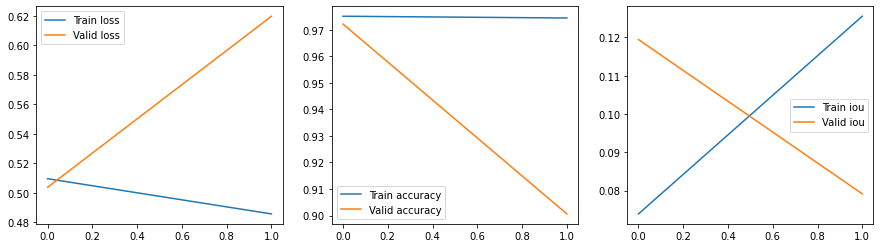

In [51]:
plt.figure(figsize=(15,4))
plt.subplot(131)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(history.epoch, history.history["accuracy"], label="Train accuracy")
plt.plot(history.epoch, history.history["val_accuracy"], label="Valid accuracy")
plt.legend()
plt.subplot(133)
plt.plot(history.epoch, history.history["mean_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_mean_iou"], label="Valid iou")
plt.legend()
plt.show()

##### Lets predict and visulaise some images

In [52]:
model.load_weights('/kaggle/working/model_0.5037.h5')

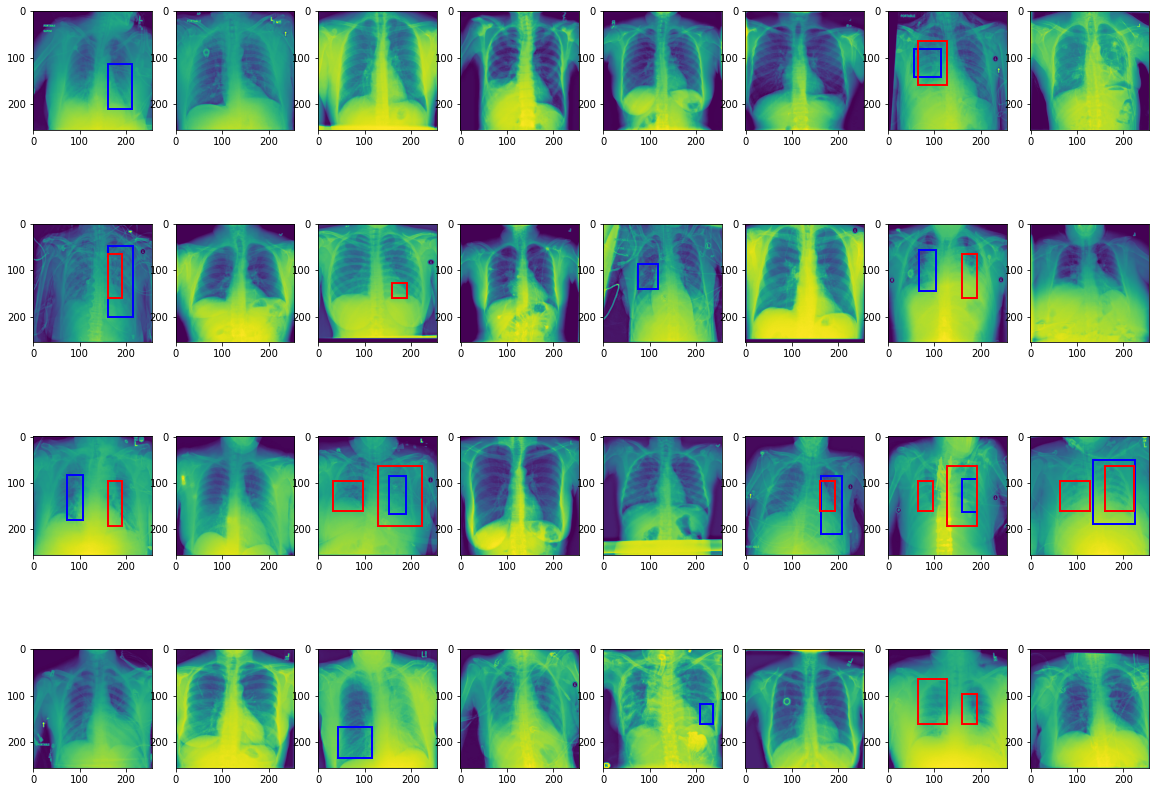

In [53]:
for imgs, msks in valid_gen:
    # predict batch of images
    preds = model.predict(imgs)
    # create figure
    f, axarr = plt.subplots(4, 8, figsize=(20,15))
    axarr = axarr.ravel()
    axidx = 0
    # loop through batch
    for img, msk, pred in zip(imgs, msks, preds):
        if axidx >= len(axarr):
            break
        # plot image
        axarr[axidx].imshow(img[:, :, 0])
        # threshold true mask
        comp = msk[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='b',facecolor='none'))
        # threshold predicted mask
        comp = pred[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='r',facecolor='none'))
        axidx += 1
    plt.show()
    break

##### Test Images Predections:

In [54]:
testfolder = 'stage_2_test_images'
test_filenames = os.listdir(testfolder)
print('n test samples:', len(test_filenames))

n test samples: 3000


In [55]:
# create test generator with predict flag set to True
test_gen = generator(testfolder, test_filenames, None, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=False, predict=True)

In [56]:
# create submission dictionary
submission_dict = {}
# loop through testset
for imgs, filenames in test_gen:
    # predict batch of images
    preds = model.predict(imgs)
    # loop through batch
    for pred, filename in zip(preds, filenames):
        # resize predicted mask
        pred = resize(pred, (1024, 1024), mode='reflect')
        # threshold predicted mask
        comp = pred[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            # proxy for confidence score
            conf = np.mean(pred[y:y+height, x:x+width])
            # add to predictionString
            predictionString += str(conf) + ' ' + str(x) + ' ' + str(y) + ' ' + str(width) + ' ' + str(height) + ' '
        # add filename and predictionString to dictionary
        filename = filename.split('.')[0]
        submission_dict[filename] = predictionString
    # stop if we've got them all
    if len(submission_dict) >= len(test_filenames):
        break

# save dictionary as csv file
sub = pd.DataFrame.from_dict(submission_dict,orient='index')
sub.index.names = ['patientId']
sub.columns = ['PredictionString']
sub.to_csv('/kaggle/working/submission.csv')

##### Lets visualize some test images with predicted mask:

In [57]:
# create test generator with predict flag set to Flase
test_gen1 = generator(testfolder, test_filenames, None, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=False, predict=False)

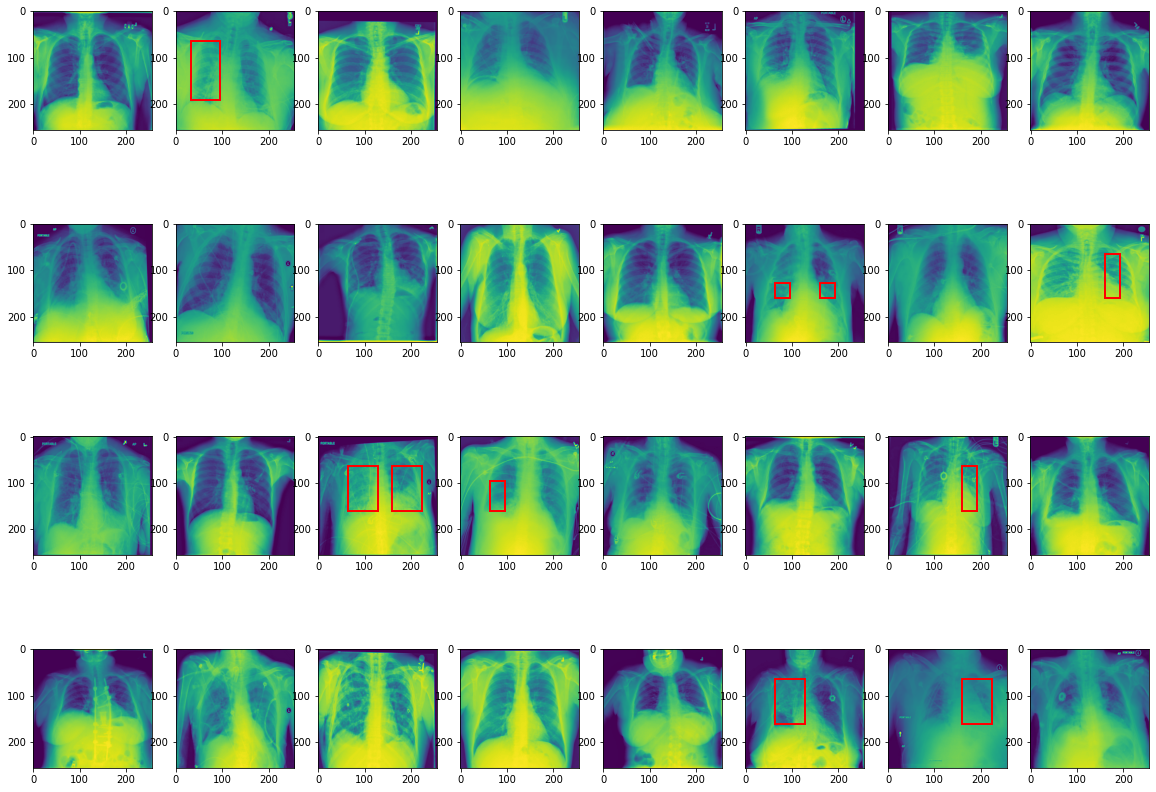

In [58]:
for imgs, msks in test_gen1:
    # predict batch of images
    preds = model.predict(imgs)
    # create figure
    f, axarr = plt.subplots(4, 8, figsize=(20,15))
    axarr = axarr.ravel()
    axidx = 0
    # loop through batch
    for img, msk, pred in zip(imgs, msks, preds):
        if axidx >= len(axarr):
            break
        # plot image
        axarr[axidx].imshow(img[:, :, 0])
        # threshold true mask
        comp = msk[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='b',facecolor='none'))
        # threshold predicted mask
        comp = pred[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='r',facecolor='none'))
        axidx += 1
    plt.show()
    break

We can see Basic CNN model given accuracy: 0.9751 and val_accuracy: 0.9721 with 5 Epochs, if we can train the model more epochs we can get more good accuracy. But due to computational linitations i cannot able to train more than 5 epochs, still its given good accuracy.

May be using Grid seach can find best parameters to train the model to get more better accuracy. I will try this further in next phases using other pretrained models like MobileNet, VGG, RCN, FCN etc..to see the results and performance      